# Introduction
This notebook is the third in a series of notebooks illustrating how to interface a model to Certifai, run a  scan and perform some simple analyses

## Part 3 - View and Analyse the results
In this notebook we'll perform a simple analysis of the explanations produced to generate a global feature occurance histogram, which shows the distribution of features occuring in the counterfactual changes.

To actually view the individual explanations in more detail use the certifai console which includes a UI to display them in a more easily viewable way than we can easily generate in a notebook

# Locate the reports
Note that the `scan.run` call we made in the previous notebook actually returns a dictionary of the reports, but we can also load reports generally from wherever they have been put, so here we'll just locate and reload them

In [1]:
from certifai.scanner.report_reader import ScanReportReader
import pandas as pd

reader = ScanReportReader("reports")
scans = reader.list_scans('German_credit_use_case')
data=[[s['date'], ', '.join(s['reportTypes']), s['id']] for s in scans]
df = pd.DataFrame(data, columns=['date', 'evals', 'scan id']).sort_values(by=['date'], ascending=False)
latest_scan = df[df['evals'].str.contains('fairness') & df['evals'].str.contains('explanation')].iloc[0]
results = reader.load_scan('German_credit_use_case', latest_scan['scan id'])

# Extract the explanations

In [2]:
from certifai.scanner.explanation_utils import (construct_explanations_dataframe, explanations, 
                                                counterfactual_feature_frequency)

explanation_df = construct_explanations_dataframe(explanations(results))
display(explanation_df)

,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,...,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
0,dtree,1,original,0,original prediction,1,0.00,... >= 200 DM / salary assignments for at leas...,6,critical account/ other credits existing (not ...,...,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no
1,dtree,1,counterfactual,1,prediction changed,2,1.00,... >= 200 DM / salary assignments for at leas...,6,all credits at this bank paid back duly,...,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no
2,dtree,2,original,0,original prediction,2,0.00,... < 0 DM,28,existing credits paid back duly till now,...,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes
3,dtree,2,counterfactual,1,prediction changed,1,1.00,... < 0 DM,28,existing credits paid back duly till now,...,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes
4,dtree,3,original,0,original prediction,1,0.00,no checking account,24,existing credits paid back duly till now,...,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,logistic,998,counterfactual,1,prediction changed,2,1.00,no checking account,36,all credits at this bank paid back duly,...,2,"car or other, not in attribute 6",> 25 years,none,own,1,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes
3996,logistic,999,original,0,original prediction,1,0.00,... >= 200 DM / salary assignments for at leas...,36,existing credits paid back duly till now,...,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes
3997,logistic,999,counterfactual,1,prediction changed,2,1.00,... >= 200 DM / salary assignments for at leas...,36,existing credits paid back duly till now,...,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes
3998,logistic,1000,original,0,original prediction,2,0.00,0 <= ... < 200 DM,54,no credits taken/ all credits paid back duly,...,4,unknown / no property,> 25 years,none,rent,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


# Analyse global feature occurrence
Now we've got a Dataframe containing the originals and counterfactuals for each row in the dataset we can use this to perform various analyses.  Here we plot global feature occurrence in the explanations

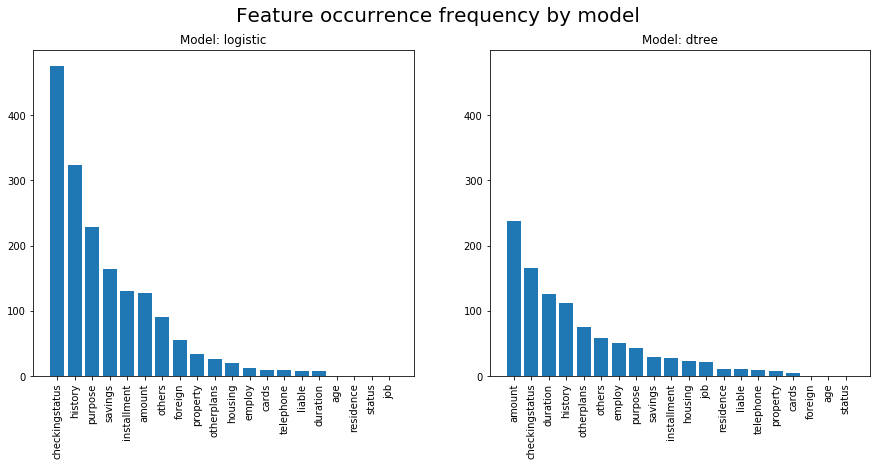

In [3]:
# Plot a histogram of frequency of occurrence of changes to each feature in counterfactuals
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(ax, model_id):
    model_explanation_df = explanation_df[explanation_df['model']==model_id]
    changes = counterfactual_feature_frequency(model_explanation_df)
    sorted_changes = changes.sort_values(ascending=False)
    indexes = np.arange(len(sorted_changes))
    ax.bar(indexes,sorted_changes.values)

    ax.ylabel = 'Frequency'
    ax.set_title(f'Model: {model_id}')
    ax.set_xticks(indexes)
    ax.set_xticklabels(sorted_changes.index, rotation=90)
    return changes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])
fig.suptitle('Feature occurrence frequency by model', fontsize=20)

logistic_changes = plot_histogram(ax1, 'logistic')
dtree_changes = plot_histogram(ax2, 'dtree')

# Put them both on the same scale
ylim = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(top=ylim)
ax2.set_ylim(top=ylim)

plt.show()

# Normalize and Compare
To make comparison between the models a bit easier let's now plot the histograms above as normlized distributions both on the same chart.  This normalization is useful because the overall complexity of the logistic model's explanations is higher (individual explanations tend to include more features).  Individually (refer to the console to see the explanations in an easy-to-view form) the logistic model's explanations have more changed features, and so are a bit harder to digest.  Conversely we can see from the training notebook that the logistic model was significantly more accurate - this tension between simplicity and subtlety will often occur when comparing models of different families, and often there will be a trade-off between simplicity of explanation and accuracy.

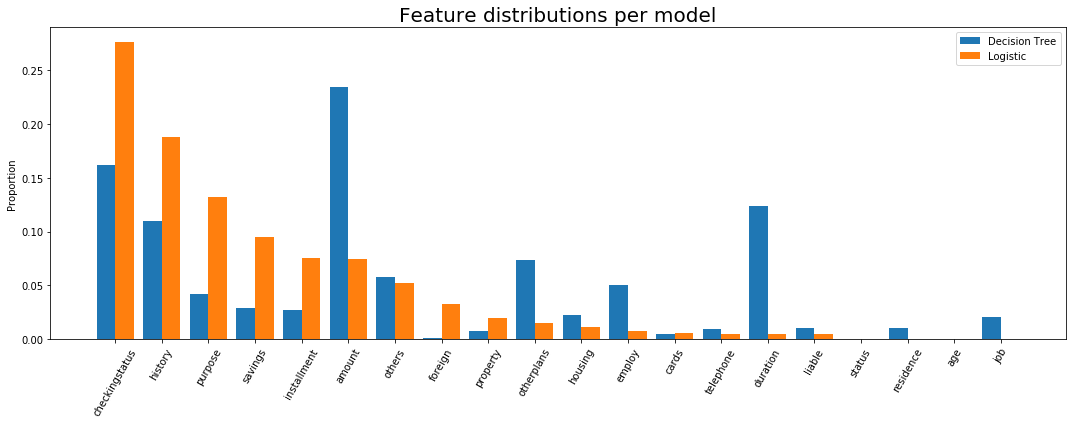

In [4]:
dtree_normalized = dtree_changes/dtree_changes.sum()
logistic_normalized = logistic_changes/logistic_changes.sum()

order = np.argsort(-logistic_normalized)
x = np.arange(len(dtree_normalized))
width = 0.4

fig, ax = plt.subplots(figsize=[15,6])

ax.bar(x-width/2, dtree_normalized.values[order], width, label='Decision Tree')
ax.bar(x+width/2, logistic_normalized.values[order], width, label='Logistic')
ax.set_ylabel('Proportion')
ax.set_title('Feature distributions per model', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(logistic_normalized.index[order], rotation = 60)
ax.legend()

fig.tight_layout()
plt.show()